## 6.832: Problem Set #5 - Part 1 of 2

Due on Friday, May 3, 2019 at 23:59.  See course website for submission details. Use Drake release tag `drake-20190423`, i.e. use this notebook via `./docker_run_notebook.sh drake-20190423 .`, or whichever script you need for your platform.

## Analyzing Manipulation via Optimization

In the first part of this problem set, we will do a couple simple analyses of: "which grasps are good?"  In the second part of the problem set, we'll use these good grasps to do a dynamic manipulation task.

### Force Closure

Force closure is an important concept in manipulation. Given a configuration with a robot grasping an object at some set of contact points, we say there is <i>force closure</i> if the robot can exert an arbitrary force and torque on the object by applying forces at the contact points. Note that for this problem, we will not consider the kinematics or dynamics of the robot itself--merely the quality of the grasp, as determined by the contact points.

<p align="center">
  <img src="closure.png" width="350"/>
</p>

For simplicity, we will consider a planar model, with contact forces $f_i \in \mathbb{R}^2$.
Write each force in its own frame of the contact, so the set of feasible forces within the friction cone is expressed as $f_i = \begin{bmatrix} f_{i,x} \\ f_{i,z} \end{bmatrix}$ with $|f_{i,x}| \leq \mu f_{i,z}$ and $f_{i,z} \geq 0$, observing that these can be rewritten as linear constraints. 

Note that a force $f_i$ has $f_{i,x}$ in the tangential direction to the surface it is touching ($t_i$ is a unit vector tangential to the surface) and $f_{i,z}$ is in the direction of the normal component $n_i$ of the surface.  The above figure depicts three contact points, where for one of the contact points, the friction cone is shown (bottom left), for one the normal and tangential vectors to the surface are shown (bottom right), and for the top one the position vector $r_i$ from the center of mass is shown. If you'd like to read more about force closure, here is a [useful reference](https://www.springer.com/cda/content/document/cda_downloaddocument/9783319018324-c2.pdf?SGWID=0-0-45-1432939-p175383086).

The net wrench $w$ (the combined forces and torques) on the object is $w = \begin{bmatrix} \sum_i (f_{i,x}t_i + f_{i,z}n_i) \\ \sum_i r_i \times (f_{i,x}t_i + f_{i,z}n_i) \end{bmatrix}$.

We can see that we can write $w = G f$, for some matrix $G$ (depending on $r_i,n_i,t_i$) where $f$ is the stacked vector of forces.  Notice carefully how we get that, for our 2D problem, $w$ ends up being of dimension 3.  What is the dimension of $f_{i,x}$? How about $t_i$? 

It can also be shown that the question of force closure can be reduced to this problem: 
<ul>
  <li>Check that $G$ is full row rank,</li>
  <li>find $f$ such that $Gf=0$</li>
  <li>and $f$ is in the <i>interior</i> of the set of allowable forces (i.e., in friction cone). Otherwise stated, $f_{i,z} > 0, \quad |f_{i,x}| < \mu f_{i,z} \quad$ for all $i$.</li>
</ul>


The rank condition can easily be checked, but the other two points are slightly more difficult. After checking that $G$ is full rank, we would like to write a Linear Program (LP) that checks, for some $r_i$'s, whether or not a grasp has force closure.
Recall that an LP is an optimization of the form:

\begin{align}
\min_z & \quad c^Tz \\
\text{s.t.} & \quad Az = b \\
& \quad Cz \leq d
\end{align}

For some matrices $A$ and $C$ and vectors $c,b,d$.  Also recall that by using a framework like Drake's MathematicalProgram, you do not have to specifically form a matrix $c$, $A$, $b$, $C$, $d$ above -- you can instead just add linear constraints, equalities, and costs, and they will get parsed into the form that the solvers like. 


## Force closure via an LP

Write an LP such that $c^Tz = 0$ if and only if there is <b>no</b> force closure, and $c^Tz < 0$ when there is force closure.

In particular, you need to implement this function signature in `force_closure.py`:

```python
def achieves_force_closure(points, normals, mu):
    """
    This will return True or False based on whether or not the given points, normals, 
    and friction coefficient mu satisfy force closure.
    
    See grasp_metrics.py for more documentation.
    """

```

HINT: The force closure formulation asked for strict inequalities ($>$ and $<$) but the LP has only $\leq$. Introduce a slack variable $\gamma \leq 0$, constrain it to be between $-1$ and $0$, and then try to minimize it.  (In other words, let $z = \begin{bmatrix} \gamma \\ f \end{bmatrix}$ and $c$ such that $c^Tz=\gamma$). Incorporate $\gamma$ into the constraints above such that $\gamma < 0$ implies that $f_{i,z} > 0$ and $|f_{i,x}| < \mu f_{i,z}$ for all $i$

Also make sure that all decision variables in the LP are bounded (that there is no feasible $z$ such that $c^Tz = \infty$)!

### Solver tips:

To make the solver work well (it should work very well for this LP, once posed correctly), please keep these in mind:

1. This is an LP, so if you use Drake's MathematicalProgram, it should only be receiving calls of `AddLinearConstraint()` and `AddLinearCost()`, or equivalent.  
2. For any arrays, you still must iterate over the array and set contraints 1-by-1 for each element
3. No slack other than the specific $\gamma$ slack variable as described should be used.
4. If you have an equality constraint, it will work fine on this problem to say `AddLinearConstraint(a == b)`
4. For this problem the solver needs bounds on all decision variables, even if they are not in the cost. Recommend:

    1. Lower-bound $\gamma$ to be -1 and upper-bound it to be 0.
    2. Add an upper and lower bound on the forces decision variables to be $>= -1000$ and $<= 1000$.

---

We have decided to help you out and already compute the G matrix for you (see `get_G()` in `grasp_metrics.py`).

We've also provided code to help you plot the inputs to your `achive_force_closure()` function, to help with intuition on whether or not your implementation is working.

In [62]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from grasp_metrics import plot_points_with_normals

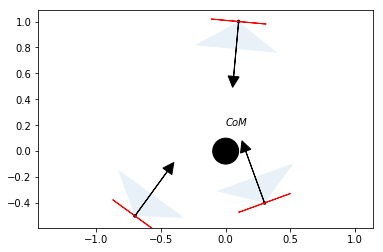

In [63]:
r1 = np.asarray([0.1, 1])
r2 = np.asarray([0.3,-0.4])
r3 = np.asarray([-0.7,-0.5])
points = [r1, r2, r3]
n1 = np.asarray([-0.1,-1.1])
n1 = n1 / np.linalg.norm(n1)
n2 = np.asarray([-0.4,1.1])
n2 = n2 / np.linalg.norm(n2)
n3 = np.asarray([0.8,1.1])
n3 = n3 / np.linalg.norm(n3)
normals = [n1, n2, n3]
mu = 1.5

plot_points_with_normals(points, normals, mu)

It should be not too hard to see that we'd expect the above three contact points to achieve force closure.

In [88]:
from grasp_metrics import achieves_force_closure
print achieves_force_closure(points, normals, mu)

[Variable('forces_x(0)', Continuous) Variable('forces_z(0)', Continuous)
 Variable('forces_x(1)', Continuous) Variable('forces_z(1)', Continuous)]
(forces_z(0) - forces_z(1))
(forces_x(0) + forces_x(1))
( - forces_x(0) + forces_x(1))
acheived force closure, gamma = [-1.]
True


Here's an even simpler set of contact points that should definitely achieve force closure, even with a much smaller friction coefficient.

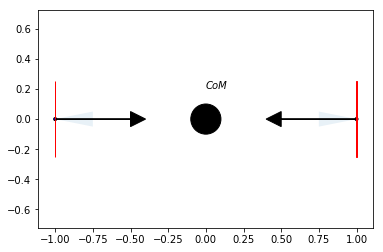

[Variable('forces_x(0)', Continuous) Variable('forces_z(0)', Continuous)
 Variable('forces_x(1)', Continuous) Variable('forces_z(1)', Continuous)]
(forces_z(0) - forces_z(1))
(forces_x(0) + forces_x(1))
( - forces_x(0) + forces_x(1))
acheived force closure, gamma = [-1.]
True


In [89]:
points  = [np.asarray([-1.0,0.]), np.asarray([1.0,0.])]
normals = [np.asarray([1.0,0.]), np.asarray([-1.0,0.])]
mu = 0.2
plot_points_with_normals(points, normals, mu)
print achieves_force_closure(points, normals, mu)

You may have noticed that force closure is a binary, "is or is not" quality of a set of grasp points.

What if we would like to compare different grasps, and have an idea of which one is better?  Simply put, we'd like some scalar that is the "score" of a certain grasp.

There are many different such analytic grasp metrics, but a simple one we will use is the **volume of the convex hull of the grasp points**.  Notice here that we are using "volume" as a [generalization to n-dimensions](https://en.wikipedia.org/wiki/Volume_of_an_n-ball) from what it is in 3D.  (I.e., in 2D, this is the "area".) This idea is briefly referred to in Section 3.2.2 here: https://personalrobotics.ri.cmu.edu/files/courses/papers/SuarezEtal06.pdf  

## Volume of the convex hull of grasp points

This should be much simpler than the force closure component from before, you just need to implement this function:

```python
def compute_convex_hull_volume(points):
    """
    Return the volume of the convex hull of the grasp points.  Should return 0
    for only two grasp points.
    
    See force_closure.py for more documentation.
    """
```

Notice also that while force closure depended on our friction coefficient, and normals, here this metric depends on neither.  Notice also that if we have only two points, the volume is always zero.  What do you think, does this make it an incomplete metric?  It definitely is, but it's a simple way to help us get reasonable multi-finger grasps.

To make sure we have a sense of what a convex hull looks like, here is a plot taken straight from the [scipy documentation example](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html):

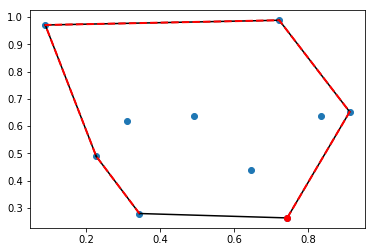

In [45]:
from scipy.spatial import ConvexHull
points = np.random.rand(10, 2)   # 30 random points in 2-D
hull = ConvexHull(points)
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

Hint: if you briefly look over the scipy ConvexHull documentation, then this problem should be very easy.

If we constrain our grasps to be on the unit circle, then we should get an expected grasp that spreads out around the circle.

In [ ]:
from grasp_metrics import compute_convex_hull_volume

print "Initial random grasp points"
random_thetas = [np.random.rand()*2*np.pi for _ in range(3)]
random_points = [np.array([np.sin(theta), np.cos(theta)]) for theta in random_thetas]
normals      = [-x/np.linalg.norm(x) for x in random_points]
plot_points_with_normals(random_points, normals, 0.1)
volume  = compute_convex_hull_volume(random_points)
"Initial volume", volume

print "Randomly sampling grasp points"
best_volume = volume
best_points = random_points
normals_of_best_points = normals

for j in range(100):
    random_thetas = [np.random.rand()*2*np.pi for _ in range(3)]
    random_points = [np.array([np.sin(theta), np.cos(theta)]) for theta in random_thetas]
    normals      = [-x/np.linalg.norm(x) for x in random_points]
    volume = compute_convex_hull_volume(random_points)
    if volume > best_volume:
        best_volume = volume
        best_points = random_points
        normals_of_best_points = normals

print "Best grasp points found"
plot_points_with_normals(best_points, normals_of_best_points, 0.1)
print "best_volume", best_volume

## Criterion of the largest ball in Grasp Wrench Space

An even better metric is to use "what is the smallest wrench that cannot be resisted?", and try to make this large.

Given that we can already compute $G$, and $w = Gf$, if we put constraints on how large each of our $f$ can be, then it is not too difficult to compute the polygedron of all possible $w$.  In particular, if the sum of each $f_{i,z}$ force is constrained to be less than 1, i.e. $\sum_{i=1}^{N}f_{i,z}<1$, then we can compute the polyhedron of all possible $w$ by iterating over each $f_i$, setting it to be 1 and the others 0, and taking the convex hull of the resultant $w_i$ points.  This set $\mathcal{P}$ is sometimes referred to as Grasp Wrench Space.  You can read more in [Section 3.3.1](https://personalrobotics.ri.cmu.edu/files/courses/papers/SuarezEtal06.pdf) of Suarez et al.. We then care about the largest ball of external wrenches that can be resisted, by appling our own counter-wrench.  This turns out to be the largest ball (sphere in our 3D wrench space for a 2D world) that can be inscribed inside the Grasp Wrench Space, where $\partial P$ is the boundary of $P$.  I.e., we want to maximize this metric:

$$ Q = \underset{w \in \partial P}{min} \ \  ||w||$$

This isn't too difficult to compute: we would just need to compute the polyhedron of grasp wrench space, and then inscribe the largest ball we can.  But we'd rather you focus more time on your final projects, and the simple "area of convux hull of grasp points" metric will work fine for our simple objects we'll manipulate in this project.

## Run Tests

In [90]:
import os
# Run the tests
os.popen("python test_set_5.py test_results.json")

# Print the results json for review
import test_set_5
print test_set_5.pretty_format_json_results("test_results.json")

Test Test force closure metric on some predefined grasps: 0.00/5.00.
  * [Variable('forces_x(0)', Continuous) Variable('forces_z(0)',
  * Continuous)  Variable('forces_x(1)', Continuous)
  * Variable('forces_z(1)', Continuous)] acheived force closure, gamma
  * = [-1.] [Variable('forces_x(0)', Continuous)
  * Variable('forces_z(0)', Continuous)  Variable('forces_x(1)',
  * Continuous) Variable('forces_z(1)', Continuous)
  * Variable('forces_x(2)', Continuous) Variable('forces_z(2)',
  * Continuous)] solver failed to find solution Test Failed: This
  * means that one of simple force closure checks failed

Test Test force closure metric on some random grasps: 10.00/10.00.
  * [Variable('forces_x(0)', Continuous) Variable('forces_z(0)',
  * Continuous)  Variable('forces_x(1)', Continuous)
  * Variable('forces_z(1)', Continuous)] only trivial solution with 0
  * forces found [Variable('forces_x(0)', Continuous)
  * Variable('forces_z(0)', Continuous)  Variable('forces_x(1)',
  * Continuous